# Convolutional Neural Network

In [1]:
import tensorflow

# ImageDataGenerator: getting image data from data augmentation (remember the concept of data augmentation)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display

np.random.seed(0)

In [2]:
print(tensorflow.__version__)

2.5.0


In [3]:
DIMENSION = 64

In [4]:
def conv_net(LEARNING_RATE, BATCH_SIZE, N_EPOCHS):    
    #DATA PREPROCESSING

    #PREPROCESSING TRAINING SET
    # shear, zoom, flip...those are methods of data augmentation
    # also rescale to normalize RGB coefficients from 0-255 to 0-1

    # train_datagen = ImageDataGenerator(
    #     rescale=1./255, 
    #     shear_range=0.2, 
    #     zoom_range=0.2, 
    #     horizontal_flip=True)
    train_datagen = ImageDataGenerator(
        rescale=1./255, 
        rotation_range=15, 
        width_shift_range=0.1, 
        height_shift_range=0.1, 
        brightness_range=[0.7, 1.3], 
        shear_range=15.0, 
        zoom_range=[0.9, 1.1], 
        channel_shift_range=50.0, 
        horizontal_flip=True, 
        vertical_flip=True)
    # flow_from_directory() method uses the path to a directory, to generate batches of augmented image data
    training_set = train_datagen.flow_from_directory(
        'dataset/training_set', #specified directory of training images
        target_size=(DIMENSION, DIMENSION), #normalize image size
        batch_size=BATCH_SIZE,
        class_mode='binary')

    #PREPROCESSING TEST SET
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_set = test_datagen.flow_from_directory(
        'dataset/test_set',
        target_size=(DIMENSION, DIMENSION),
        batch_size=BATCH_SIZE,
        class_mode='binary')



    #BUILDING THE CNN

    # initialize cnn
    cnn = Sequential()

    #CONVOLUTION
    # convolution is feature mapping
    # the dot products of matricial feature detector and sections of the input matrix...results in a feature map
    # many feature maps make up this convolutional layer
    # 32 feature detectors --> 32 feature maps
    # 3x3 convolution window
    cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[DIMENSION, DIMENSION, 3], use_bias=True))

    #POOLING
    # pooling involves taking the max values of certain sections of the feature map
    # pool size is 2x2
    # step size is 2
    cnn.add(MaxPooling2D(pool_size=2, strides=2))

    #MORE CONVOLUTION LAYERS
    # adding more convolution layers
    # from the 2nd layer and on, convolution "window" is now 3d
    cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', use_bias=True))
    cnn.add(MaxPooling2D(pool_size=2, strides=2))

    #FLATTEN
    # all those pooled feature maps from the previous layer become one yuge vector
    cnn.add(Flatten())

    #FULL CONNECTION
    # ann layers
    cnn.add(Dense(128, activation='relu', use_bias=True))
    # output layer
    cnn.add(Dense(1, activation='sigmoid'))



    #TRAINING THE CNN

    cnn.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])
    history = cnn.fit(training_set, validation_data=test_set, epochs=N_EPOCHS, verbose=0)
    cnn_training_eval = cnn.evaluate(training_set, batch_size=BATCH_SIZE, verbose=0)
    cnn_test_eval = cnn.evaluate(test_set, batch_size=BATCH_SIZE, verbose=0)
    return cnn, history, [cnn_training_eval, cnn_test_eval]

In [5]:
def conv_net_regularization(LEARNING_RATE, BATCH_SIZE, N_EPOCHS, LAMBDA, DROPOUT_RATE):
    train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, brightness_range=[0.7, 1.3], shear_range=15.0, zoom_range=[0.9, 1.1], channel_shift_range=50.0, horizontal_flip=True, vertical_flip=True)
    training_set = train_datagen.flow_from_directory('dataset/training_set', target_size=(DIMENSION, DIMENSION), batch_size=BATCH_SIZE, class_mode='binary')
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_set = test_datagen.flow_from_directory('dataset/test_set', target_size=(DIMENSION, DIMENSION), batch_size=BATCH_SIZE, class_mode='binary')

    cnn = Sequential()
    cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[DIMENSION, DIMENSION, 3], use_bias=True, kernel_regularizer=l2(LAMBDA)))
    cnn.add(Dropout(DROPOUT_RATE))
    cnn.add(MaxPooling2D(pool_size=2, strides=2))

    cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', use_bias=True, kernel_regularizer=l2(LAMBDA)))
    cnn.add(Dropout(DROPOUT_RATE))
    cnn.add(MaxPooling2D(pool_size=2, strides=2))
    cnn.add(Flatten())

    cnn.add(Dense(128, activation='relu', use_bias=True, kernel_regularizer=l2(LAMBDA)))
    cnn.add(Dropout(DROPOUT_RATE))

    cnn.add(Dense(1, activation='sigmoid'))

    cnn.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])
    history = cnn.fit(training_set, validation_data=test_set, epochs=N_EPOCHS, verbose=0)
    cnn_training_eval = cnn.evaluate(training_set, batch_size=BATCH_SIZE, verbose=0)
    cnn_test_eval = cnn.evaluate(test_set, batch_size=BATCH_SIZE, verbose=0)
    return cnn, history, [cnn_training_eval, cnn_test_eval]

In [6]:
def graph(history, cnn_eval, title):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    fig.suptitle(f'{title} model')
    
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    plt.setp(ax[0], ylabel='accuracy')
    ax[0].legend(['train', 'test'], loc='upper left')
    
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    plt.setp(ax[1], ylabel='loss')
    ax[1].legend(['train', 'test'], loc='upper left')
    
    plt.setp(ax, xlabel='epoch')
    plt.show()
    
    training_accuracy = cnn_eval[0][1]
    training_loss = cnn_eval[0][0]
    test_accuracy = cnn_eval[1][1]
    test_loss = cnn_eval[1][0]
    print(f'Accuracy:\t {round(training_accuracy*100, 1)}% (training)\t {round(test_accuracy*100, 1)}% (test)')
    print(f'Loss:\t\t {round(training_loss, 3)} (training)\t {round(test_loss, 3)} (test)')
    print('='*100)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


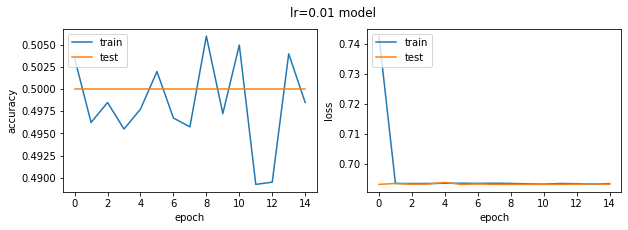

Accuracy:	 50.0% (training)	 50.0% (test)
Loss:		 0.693 (training)	 0.693 (test)
Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


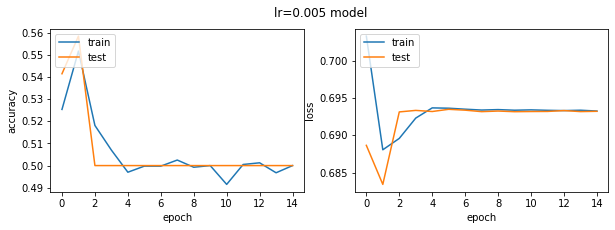

Accuracy:	 50.0% (training)	 50.0% (test)
Loss:		 0.693 (training)	 0.693 (test)
Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


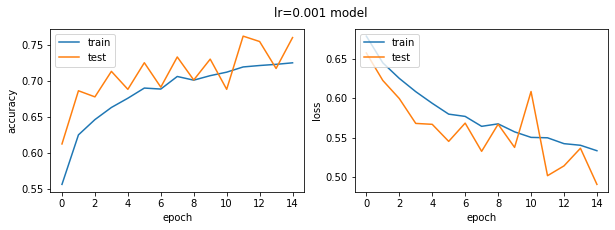

Accuracy:	 73.3% (training)	 76.0% (test)
Loss:		 0.53 (training)	 0.491 (test)
Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


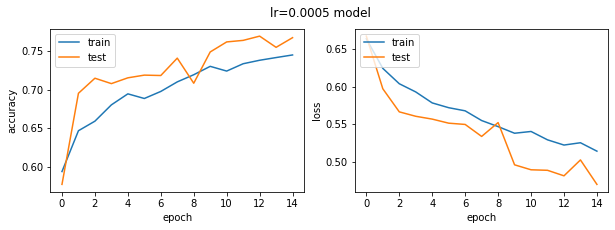

Accuracy:	 76.5% (training)	 76.7% (test)
Loss:		 0.488 (training)	 0.47 (test)
Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


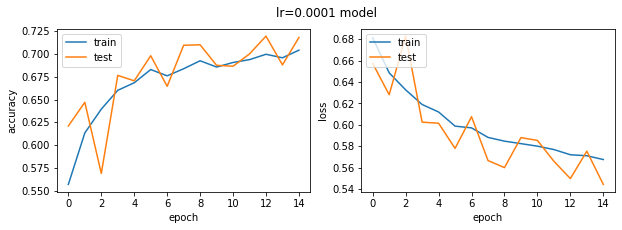

Accuracy:	 70.6% (training)	 71.8% (test)
Loss:		 0.563 (training)	 0.544 (test)


In [7]:
# what happens when the learning rate is too high?

learning_rates = [0.01, 0.005, 0.001, 0.0005, 0.0001]

for lr in learning_rates:
    cnn, history, cnn_eval = conv_net(LEARNING_RATE=lr, BATCH_SIZE=32, N_EPOCHS=15)
    graph(history, cnn_eval, f'lr={lr}')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


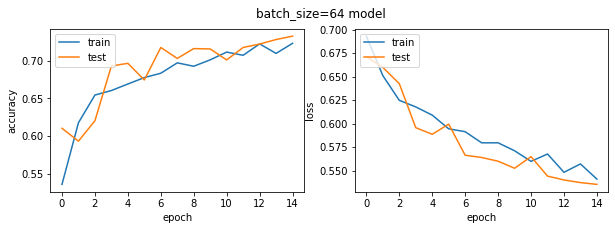

Accuracy:	 72.1% (training)	 73.3% (test)
Loss:		 0.543 (training)	 0.536 (test)
Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


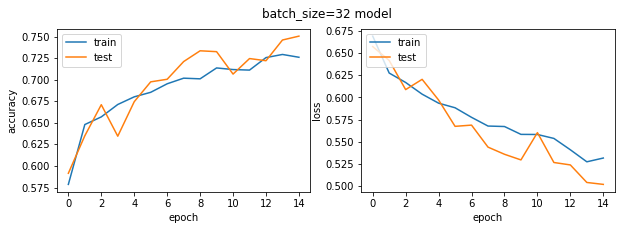

Accuracy:	 73.8% (training)	 75.1% (test)
Loss:		 0.527 (training)	 0.502 (test)
Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


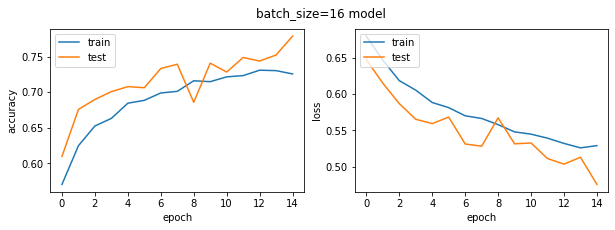

Accuracy:	 74.2% (training)	 77.9% (test)
Loss:		 0.516 (training)	 0.476 (test)
Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


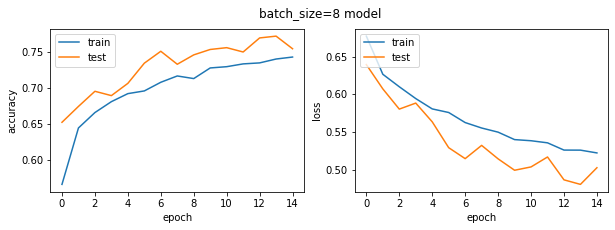

Accuracy:	 75.6% (training)	 75.4% (test)
Loss:		 0.502 (training)	 0.502 (test)


In [7]:
# we choose learning rate 0.0005

batch_sizes = [64, 32, 16, 8]

for bs in batch_sizes:
    cnn, history, cnn_eval = conv_net(LEARNING_RATE=0.0005, BATCH_SIZE=bs, N_EPOCHS=15)
    graph(history, cnn_eval, f'batch_size={bs}')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


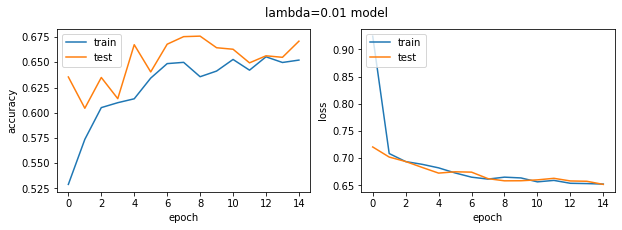

Accuracy:	 66.2% (training)	 67.1% (test)
Loss:		 0.651 (training)	 0.652 (test)
Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


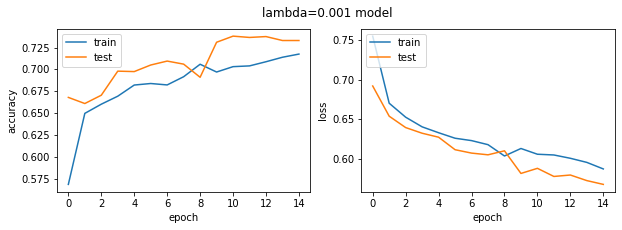

Accuracy:	 72.5% (training)	 73.3% (test)
Loss:		 0.584 (training)	 0.568 (test)
Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


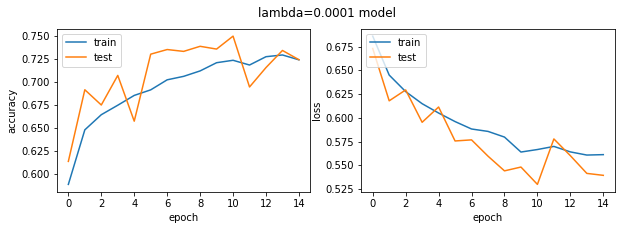

Accuracy:	 73.7% (training)	 72.4% (test)
Loss:		 0.548 (training)	 0.539 (test)
Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


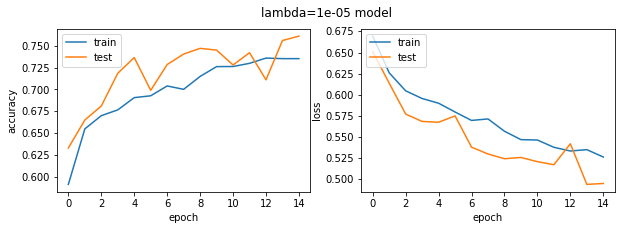

Accuracy:	 75.6% (training)	 76.1% (test)
Loss:		 0.513 (training)	 0.495 (test)
Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


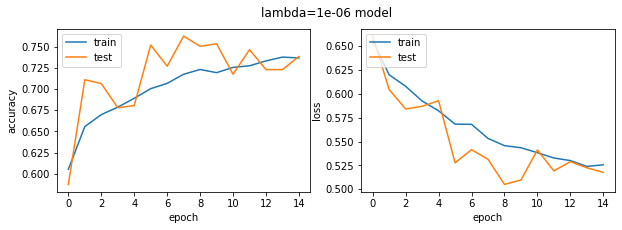

Accuracy:	 73.2% (training)	 73.8% (test)
Loss:		 0.529 (training)	 0.518 (test)


In [7]:
# we choose learning rate 0.0005 and batch size 16
# what happens when the regularization rate is too high?

lambdas = [0.01, 0.001, 0.0001, 1e-5, 1e-6]

for l in lambdas:
    cnn, history, cnn_eval = conv_net_regularization(LEARNING_RATE=0.0005, BATCH_SIZE=16, N_EPOCHS=15, LAMBDA=l, DROPOUT_RATE=0.2)
    graph(history, cnn_eval, f'lambda={l}')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


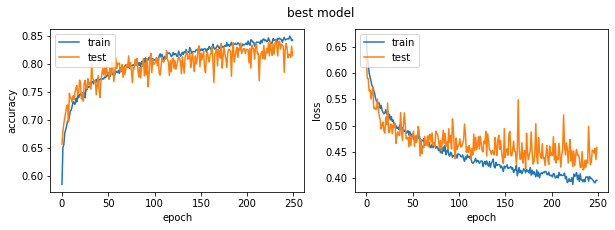

Accuracy:	 86.3% (training)	 81.6% (test)
Loss:		 0.379 (training)	 0.459 (test)


In [7]:
# we choose learning rate 0.0005, batch size 16, and lambda 1e-5

best_model, best_history, best_eval = conv_net_regularization(LEARNING_RATE=0.0005, BATCH_SIZE=16, N_EPOCHS=250, LAMBDA=1e-5, DROPOUT_RATE=0.2)
graph(best_history, best_eval, 'best')

In [8]:
best_model.save('model')

INFO:tensorflow:Assets written to: model/assets


In [9]:
best_model = load_model('model')

In [10]:
def individual_predictions(cnn, title):
    print(f'===== {title} model individual predictions =====')
    path = 'dataset/single_prediction/'
    for img_name in os.listdir(path):
        if img_name == '.DS_Store': continue    
        img_path = os.path.join(path, img_name)
        img = image.load_img(img_path, target_size=(DIMENSION, DIMENSION))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = img/255.
        prediction = cnn.predict(img)[0][0]

        display(Image(filename=img_path, width=100, height=100))
        if prediction < 0.5: print(f'cat ({prediction})')
        else: print(f'dog ({prediction})')

===== best model individual predictions =====


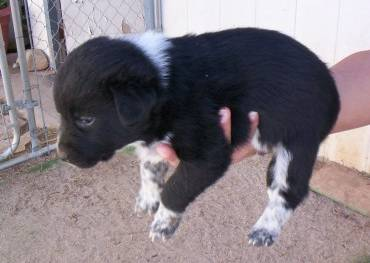

dog (0.9584013223648071)


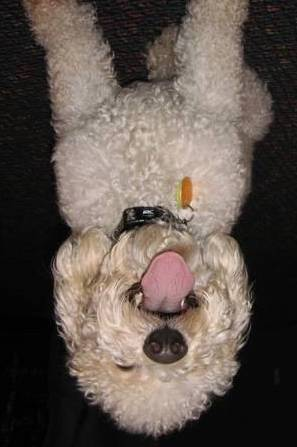

dog (0.7974495887756348)


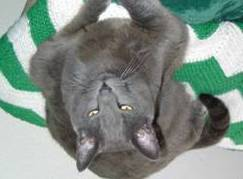

cat (0.41621753573417664)


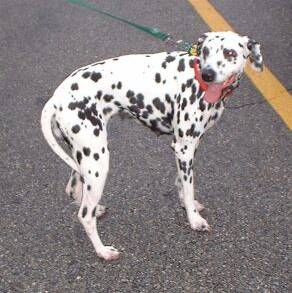

dog (0.9872857332229614)


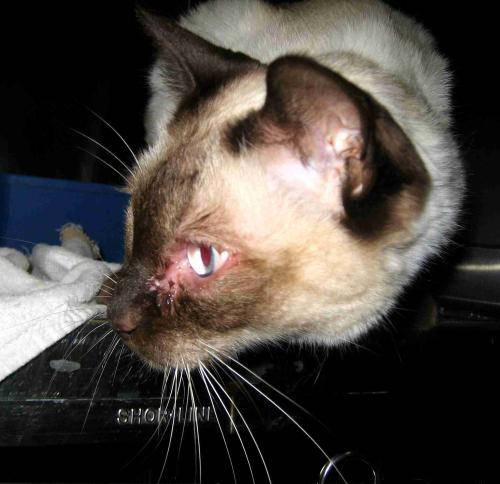

dog (0.617165744304657)


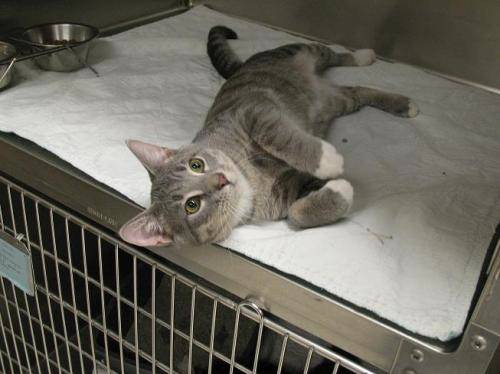

cat (0.23971772193908691)


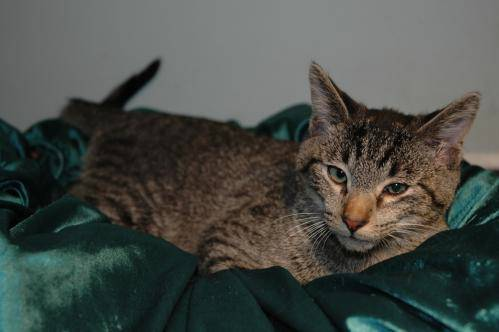

cat (0.0014041662216186523)


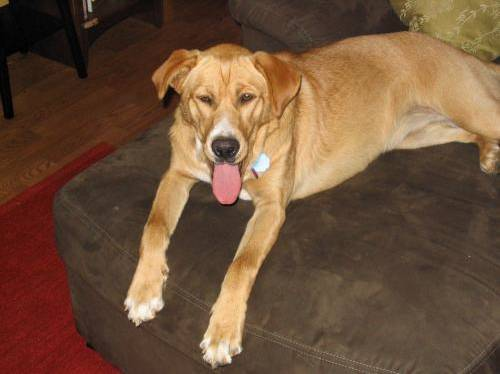

dog (0.9985300302505493)


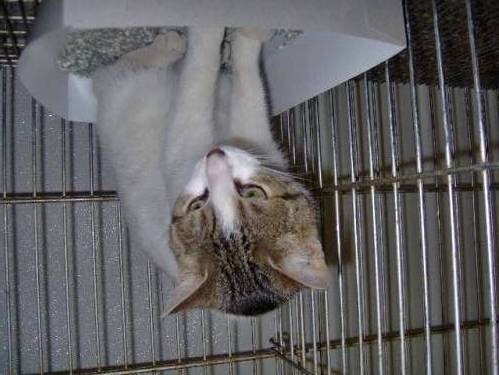

cat (0.011787831783294678)


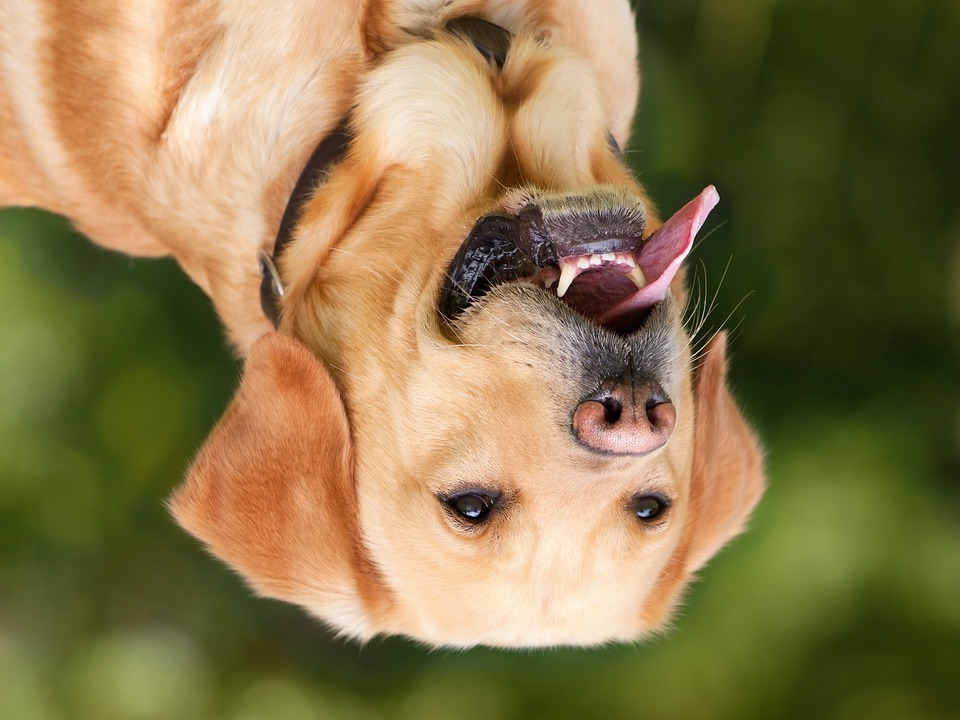

dog (0.9976726770401001)


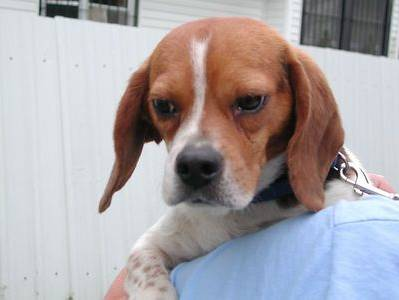

dog (0.9896607398986816)


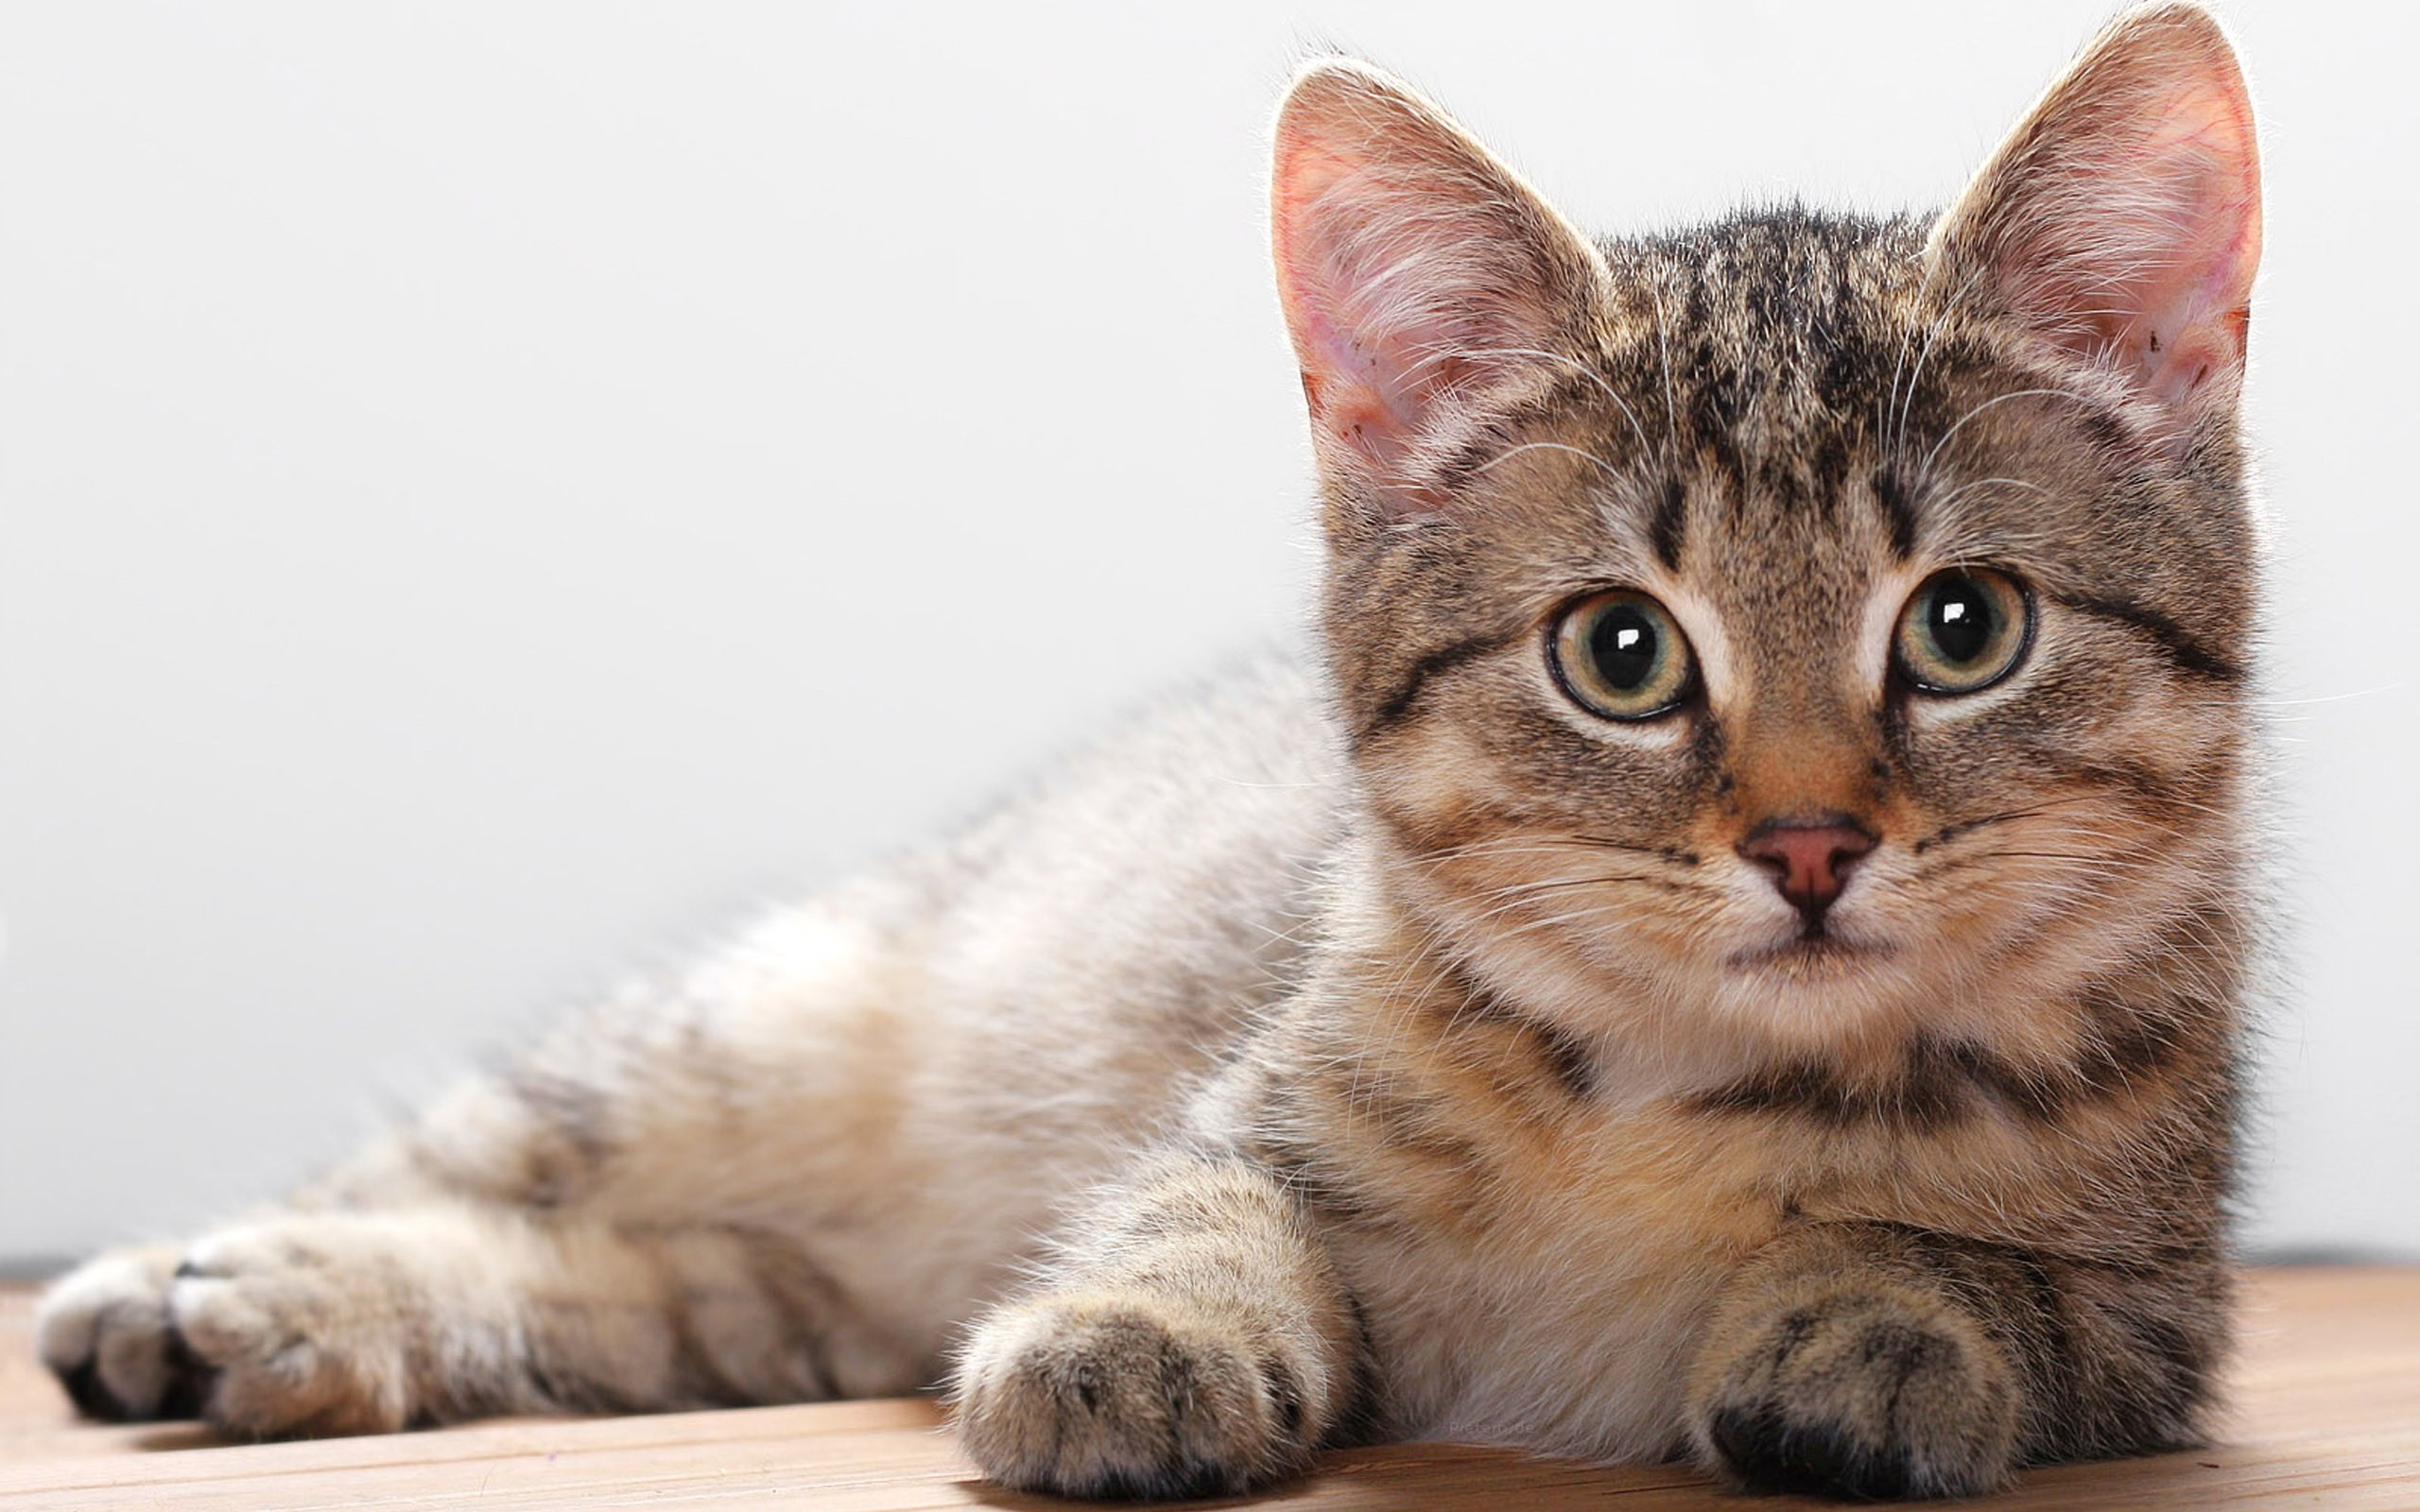

cat (0.23206520080566406)


In [11]:
# best model parameters: learning_rate=0.0005, batch_size=16, lambda=0.00001
# by the way, the class indices are {'cats': 0, 'dogs': 1}

individual_predictions(best_model, 'best')